<a href="https://colab.research.google.com/github/matiasvallejosdev/ar-dl-color-mapping/blob/main/Project.DeepLearning/cm_imageclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [7]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras as tk
import tensorflow.keras.preprocessing.image as tfi
import numpy as np
import pandas as pd

import pathlib
import imageio

import matplotlib.pyplot as plt
import os

tf.__version__

'2.7.0'

## Load data

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
EPOCHS = 5
batch_size = 12
data_root = ("/content/drive/My Drive/Machine Learning/Datasets/color-mapping/")

IMAGE_SHAPE = (128, 128) # (height, width) in no. of pixels

DATA_DIR = str(data_root)
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

print(DATA_DIR)

/content/drive/My Drive/Machine Learning/Datasets/color-mapping/


## Prepare data to train

In [35]:
def plotImages(images_arr, size):
    fig, axes = plt.subplots(1, size, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [36]:
train_dir = DATA_DIR + "train/"
test_dir = DATA_DIR + "test/"
valid_dir = DATA_DIR + "valid/"

print(train_dir)
print(test_dir)
print(valid_dir)

/content/drive/My Drive/Machine Learning/Datasets/color-mapping/train/
/content/drive/My Drive/Machine Learning/Datasets/color-mapping/test/
/content/drive/My Drive/Machine Learning/Datasets/color-mapping/valid/


In [37]:
# Define generators
train_datagen = tfi.ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest")

test_datagen = tfi.ImageDataGenerator(rescale=1 / 255.0)

In [38]:
# Define datasets
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    #save_to_dir=train_dir,
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=batch_size,
    shuffle=True,
    seed=4
)
valid_generator = train_datagen.flow_from_directory(
    directory=valid_dir,
    #save_to_dir=valid_dir,
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=batch_size,
    shuffle=True,
    seed=4
)
test_generator = test_datagen.flow_from_directory(
    directory= test_dir,
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=batch_size,
    shuffle=False
)

Found 104 images belonging to 2 classes.
Found 43 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [39]:
class_names = train_generator.classes
print("Total classes: {}".format(train_generator.num_classes))

class_names = train_generator.class_indices
print("Name classes: {}".format(class_names))
print("Total: {}".format(str(len(class_names))))

Total classes: 2
Name classes: {'batman': 0, 'captain': 1}
Total: 2


In [40]:
imgs, labels = next(train_generator)

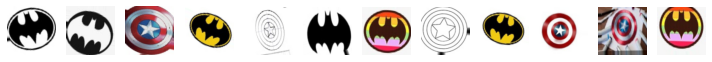

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [41]:
plotImages(imgs, batch_size)
print(labels)

## Define model

In [42]:
model = tf.keras.Sequential([
            tfl.Conv2D(32, 3, padding='same', activation='relu',input_shape=(128,128,3)),
            tfl.MaxPooling2D(),
            tfl.Conv2D(64, 3, padding='same', activation='relu'),
            tfl.MaxPooling2D(),
            tfl.Conv2D(64, 3, padding='same', activation='relu'),
            tfl.Flatten(),
            tfl.Dense(64, activation='relu'),
            tfl.Dense(2, activation='sigmoid')
])

In [43]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 65536)            

## Train model

In [61]:
history = model.fit_generator(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=EPOCHS)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/5
8/8 [==============================] - 4s 508ms/step - loss: 0.1065 - accuracy: 0.9348 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 2/5
8/8 [==============================] - 4s 490ms/step - loss: 0.2888 - accuracy: 0.8913 - val_loss: 0.0441 - val_accuracy: 1.0000
Epoch 3/5
8/8 [==============================] - 4s 520ms/step - loss: 0.2659 - accuracy: 0.9239 - val_loss: 0.0996 - val_accuracy: 1.0000
Epoch 4/5
8/8 [==============================] - 4s 499ms/step - loss: 0.2103 - accuracy: 0.9130 - val_loss: 0.1002 - val_accuracy: 0.9722
Epoch 5/5
8/8 [==============================] - 4s 479ms/step - loss: 0.1627 - accuracy: 0.9239 - val_loss: 0.0442 - val_accuracy: 1.0000


## Test model

In [62]:
test_loss, test_accuracy = model.evaluate_generator(valid_generator)
predictions = model.predict(valid_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [63]:
print("Test loss: {}".format(test_loss))
print("Test accuracy: {}".format(test_accuracy))

Test loss: 0.03730136156082153
Test accuracy: 1.0


4/4 - 1s - loss: 0.0329 - accuracy: 1.0000 - 610ms/epoch - 152ms/step


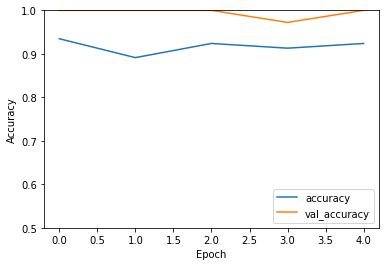

In [64]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(valid_generator, verbose=2)

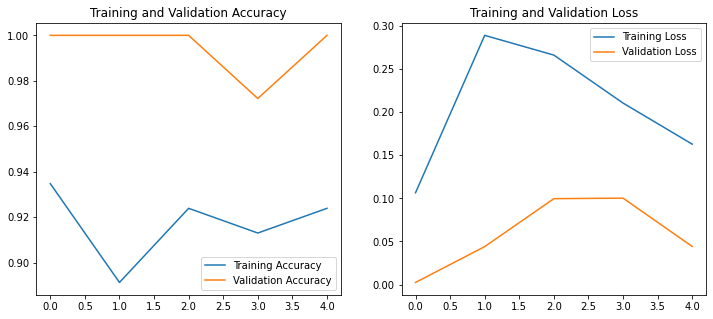

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()